# Develop an initial model and split datasets

This notebook makes a pipeline to take labelled spectrograms, split them into training and validation sets using a random sample, and re-trains an image recognition model to predict the category (call/no call) of the spectrogram. It also describes a way to look at, clean out and re-label the spectrograms which generate the highest loss. 

In [11]:
%load_ext autoreload
%autoreload 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import the required libraries

In [12]:
import pandas as pd
from pathlib import Path
import torch
from fastai.vision.all import *
from fastai.vision.widgets import *
# fastai library simplifies training fast and accurate neural nets using modern best practices
# https://www.mdpi.com/2078-2489/11/2/108/htm

### Set relative paths

In [13]:
data_path = Path('../../data')
path = Path(data_path/"interim/temp_png")

### Get a list of filenames for all the images in the training data path

In [14]:
filenames = get_image_files(path)
filenames

(#1998) [Path('../../data/interim/temp_png/call/spectrograms/recording-6714-clip-90536.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-529966-clip-977059.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-100760-clip-422149.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-100226-clip-362208.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-320901-clip-731347.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-248819-clip-952672.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-552380-clip-645239.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-292199-clip-569065.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-217279-clip-755445.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-100144-clip-349271.png')...]

In [15]:
def grandparent_label(item):
    "Label `item` with the name of the folder 2 levels up"
    return Path(item).parent.parent.name

# DataBlock
Framework for creating a dataloaders object. 
- blocks is where we specify the types of features and labels : Image as input, 2 category output (call/nocall)
- sampling 20% of the data and using that as the validation set.
- using this framework we can build a __dataloaders__ 


Some of the terminology in PyTorch and fastai can be confusing. They can have similar names which mean very specific things. Here are the definintions

- Dataset: an iterable over tuples containing images with their corresponding category.
- Datasets: a fastai class which joins together a training dataset and a validation dataset into one object.
- DataLoader: a PyTorch iterable returning a batch of datasets.
- DataLoaders: a fastai iterable which splits dataloader into training and validation datasets.
- batch: The sample of the dataset loaded in parallel and passed to the model during one training loop.


In [16]:
birds = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2),
    get_y = grandparent_label)

In [17]:
birds.summary(path)

Setting-up type transforms pipelines
Found 1998 items
2 datasets of sizes 1599,399
Setting up Pipeline: PILBase.create
Setting up Pipeline: grandparent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../../data/interim/temp_png/nocall/spectrograms/recording-44091-clip-110385.png
    applying PILBase.create gives
      PILImage mode=RGB size=224x224
  Pipeline: grandparent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../../data/interim/temp_png/nocall/spectrograms/recording-44091-clip-110385.png
    applying grandparent_label gives
      nocall
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=224x224, TensorCategory(1))


Found 1998 items
2 datasets of sizes 1599,399
Setting up Pipeline: PILBase.create
Setting up Pipeline: grandparent_label -> Categorize

This summary shows the two datasets used for training - the larger training set and the smaller validation set. 

In [18]:
dataloaders = birds.dataloaders(path)

In [19]:
x,y = dataloaders.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

- Here we can see the batch size is 64, and contains 3 channel images of 224*224 px 
- The length of the labels is just a tensor containg 64 elements. 
The 3 channel means we're loading these images into the tensor as RGB images instead of greyscale images, which is redundant, though necessary if the pretrained architecture used RGB images. In this case (resnet18 on ImageNet) it did use RGB images. 

# Show 9 items from training set. 
Note this is before any attempt to process the data to include high quality samples, or to curate a no_call dataset which doesn't contain calls of the olive sided flycatcher. This no_call dataset is made from clips tagged as species other than the olive sided flycatcher - but there could still be OSFL calls in the background. 

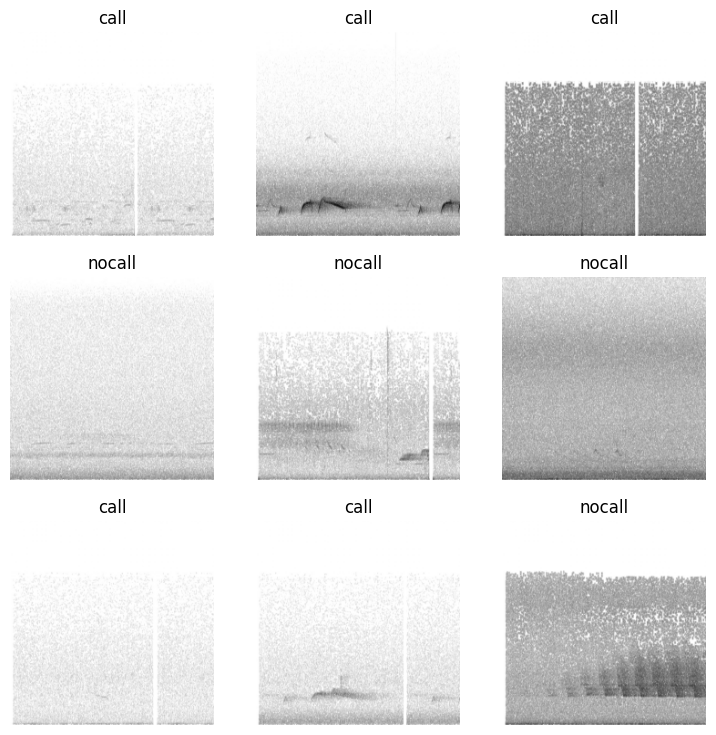

In [ ]:
dataloaders.train.show_batch(unique=False)

# Train a model using transfer learning
The model being retranined is a resnet 18 model trained on the imagenet database. 

In [21]:
learn = vision_learner(dataloaders, resnet18, metrics = error_rate)

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
%time learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.084166,1.482872,0.426065,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.763380,0.851989,0.303258,00:36
1,0.556382,0.593153,0.230576,00:35
2,0.424857,0.726012,0.208020,00:35
3,0.306853,0.687340,0.195489,00:36
4,0.207136,0.814636,0.195489,00:35
5,0.137827,0.858978,0.197995,00:35
6,0.091104,0.846101,0.195489,00:37
7,0.060768,0.831821,0.192982,00:35
8,0.040969,0.848570,0.190476,00:35
9,0.029640,0.847857,0.195489,00:35


CPU times: user 1min 15s, sys: 18.9 s, total: 1min 34s
Wall time: 6min 23s


During initial run there was an error: 
TypeError: Exception occured in `ProgressCallback` when calling event `after_batch`:
	unsupported format string passed to TensorBase.__format__
    
- Fix: Updated packages in the virtual environment - this was an issue with a change in the PyTorch package not allowing subclasses in Tensor.format
- Packages in the exported model need

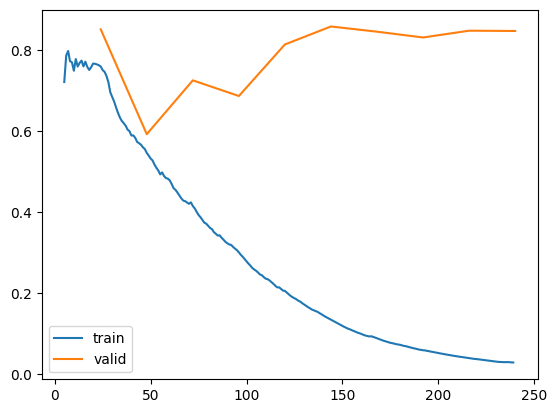

In [13]:
learn.recorder.plot_loss()

Graph interpretation
It's too early to make conclusions from the error rate values at this point due to the simple sampling method used. The validation set needs to be taken from data which is better separated from the training samples - either by time or location or both. 
- the curves are showing that the model is training.
- The blue curve shows the model's performance on items in the training set; the model is learning the specific items in the training set.

- One thing to note is that __the loss on the validation set improves quickly for the first epoch__, then gets worse thereafter. This is because during training we're freezing the parameters of the pretrained model, except for the head (final layer) of the model. We've transplanted a randomly initialized array of numbers (only two in this case) in place of the original final layer of the Resnet18 model trained on 20,000 categories. The inital frozen epoch is tailoring just the final layer of the model, and it's doing this well. 

- After the first epoch, the model is unfrozen, and all the parameters are updated with discriminative learning rates. Since the original model was trained on colour images of real world photographs, and we're passing in computer generated spectrograms, we should expect to have to do a larger amount of re-learning before these earlier layers come to learn things about spectrograms.

- The orange curve shows the model's performance on unseen samples. This is how well the model will generalise to unseen data.  To train a good model, we want to see the  orange curve reducing as the model trains.



### Let's see what happens if we allow more epochs before model unfreeze

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.108673,1.130345,0.421053,00:26
1,0.931255,1.014593,0.340852,00:25
2,0.858871,0.573568,0.248120,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.581396,0.496756,0.220551,00:38
1,0.447834,0.574623,0.220551,00:38
2,0.321342,0.638953,0.200501,00:38
3,0.228096,0.639431,0.190476,00:38
4,0.161897,0.647657,0.192982,00:37
5,0.112328,0.609320,0.185464,00:37
6,0.075789,0.604017,0.175439,00:37
7,0.053856,0.600046,0.175439,00:37


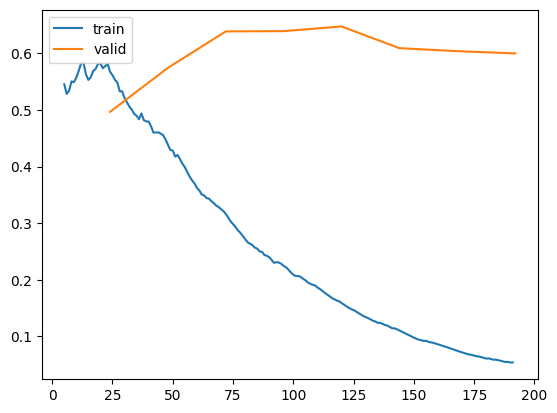

In [27]:
learn = vision_learner(dataloaders, resnet18, metrics = error_rate)
learn.fine_tune(8, freeze_epochs =  3)
learn.recorder.plot_loss()

### Let's see what happens if we reduce the learning rate after unfreezing the model

epoch,train_loss,valid_loss,error_rate,time
0,1.136735,1.768365,0.458647,00:25


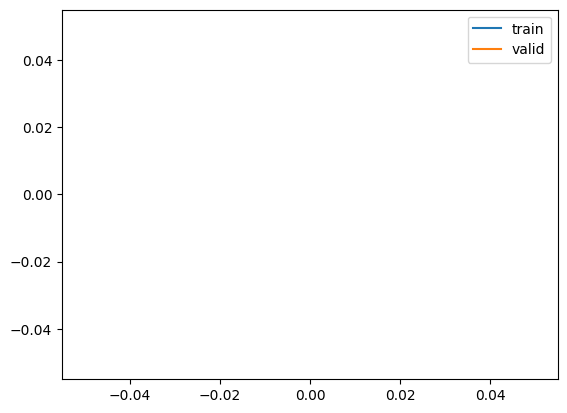

In [28]:
learn = vision_learner(dataloaders, resnet18, metrics = error_rate)
learn.fine_tune(0, freeze_epochs=1)
learn.recorder.plot_loss()

epoch,train_loss,valid_loss,error_rate,time
0,0.722889,0.860341,0.255639,00:37
1,0.557235,0.875208,0.243108,00:37
2,0.509914,0.574172,0.185464,00:37
3,0.401941,0.506914,0.160401,00:38
4,0.286258,0.509188,0.160401,00:37
5,0.194585,0.558859,0.160401,00:37
6,0.132048,0.493360,0.155388,00:38
7,0.092755,0.493342,0.147870,00:37
8,0.062294,0.496656,0.145363,00:37


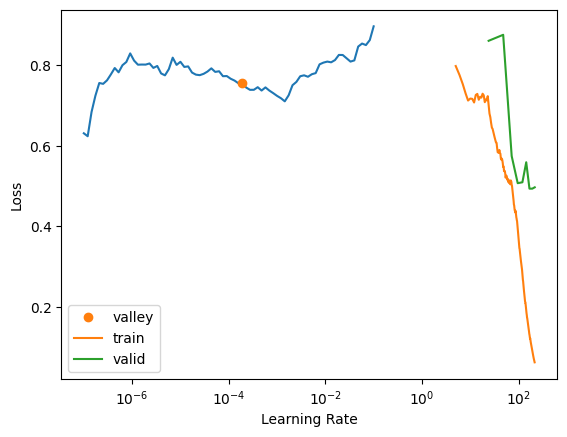

In [29]:
learn.unfreeze()
lr = learn.lr_find()
learn.fit_one_cycle(9, lr_max = lr)

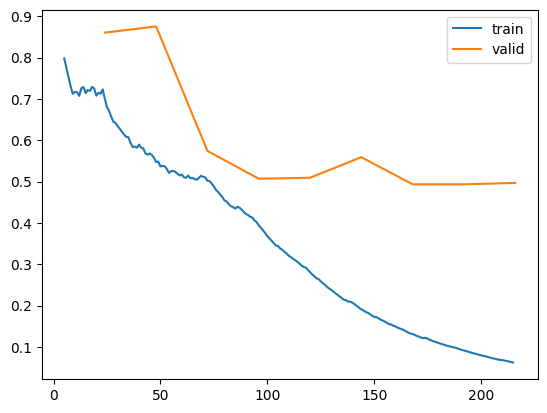

In [31]:
learn.recorder.plot_loss()

### Here we can see that the initial learning rate of 0.2e-2 was too high for the unfrozen model. Using a learning rate of 0.2e-3 results in better convergence on the validation set. 

### but 0.2e-2 is still appropriate for the initial unfrozen stage of training. 

In [1]:
lr

NameError: name 'lr' is not defined

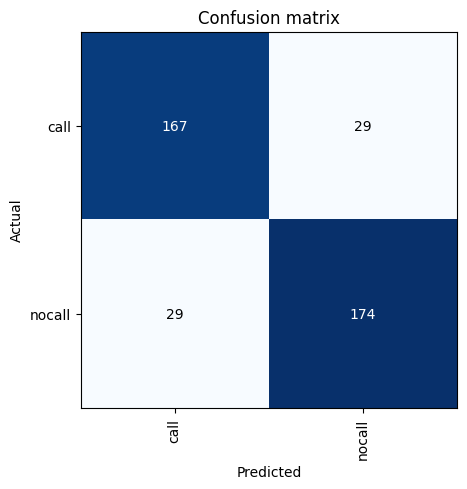

In [33]:
interpreter = ClassificationInterpretation.from_learner(learn)
interpreter.plot_confusion_matrix()

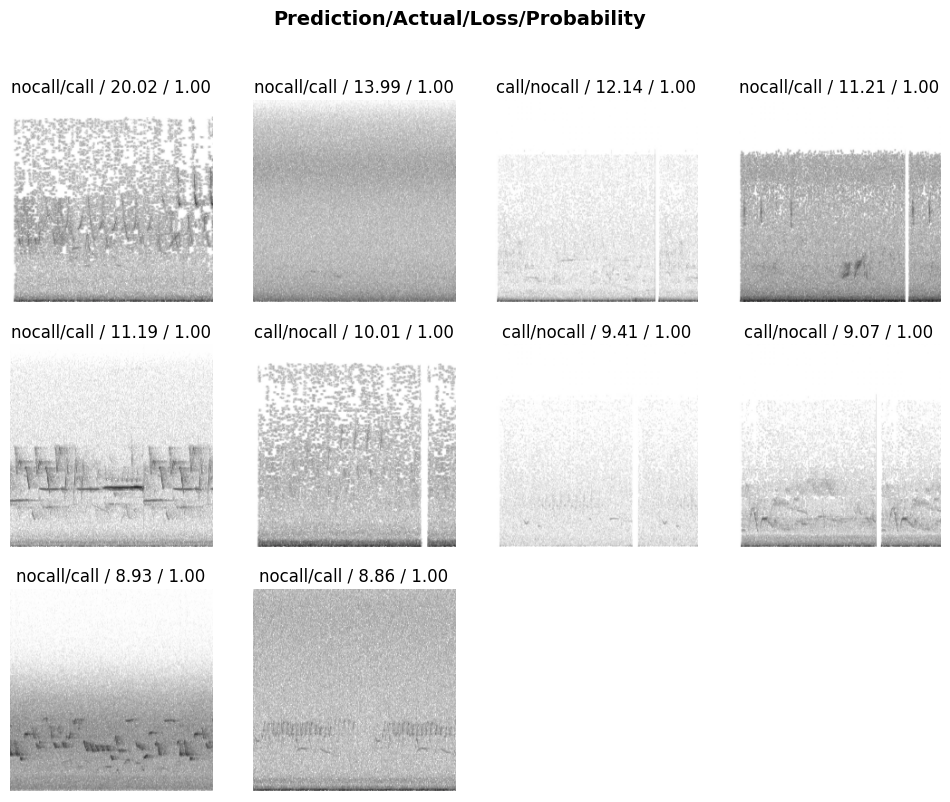

In [15]:
interpreter.plot_top_losses(10)

In [16]:
idx = 1

### Iterate through examples one by one to see the model's prediction, the spectrogram and the label

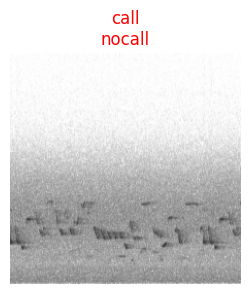

In [113]:
idx+=1
interpreter.show_results(idx)

Could this one be mis-labelled?

In [18]:
interpreter.print_classification_report()

              precision    recall  f1-score   support

        call       0.82      0.79      0.81       204
      nocall       0.79      0.82      0.80       195

    accuracy                           0.80       399
   macro avg       0.80      0.80      0.80       399
weighted avg       0.80      0.80      0.80       399



# Model driven data cleaning
Training a model early on in the development process gets us a quick look at which kinds of samples produce the highest loss. Visually, it seems like some of the files which have the highest losses are:
- reduced to a lower bit rate (white bar at the top of the image showing lack of information in high freq)
- contain some strange speckles. These could be a artifacts of an audio compression algorithm. The mp3 algorithm works by throwing away information in the frequency domain so that's probably what we're seeing here. We could throw out any low bitrate mp3 files from the training set, but only if it's a safe assumption that these encodings won't be used again in future - otherwise we'd want to include them in the training set. 

In [19]:
filenames[:10]

(#10) [Path('../../data/interim/temp_png/call/spectrograms/recording-6714-clip-90536.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-529966-clip-977059.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-100760-clip-422149.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-100226-clip-362208.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-320901-clip-731347.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-248819-clip-952672.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-552380-clip-645239.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-292199-clip-569065.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-217279-clip-755445.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-100144-clip-349271.png')]

In [20]:
cl = ImagesCleaner()

### Specific files can be passed for cleaning.
Here we're passing the first 5 items in filenames. 

In [21]:
cl.set_fns(filenames[:5])
cl

Box(children=(VBox(children=(Output(layout=Layout(height='128px')), Dropdown(layout=Layout(width='max-content'…

# Here are the 10 most incorrect (highest loss) predictions
Note that a prediction has a high loss value if it is confidently wrong, or unconfidently right. 

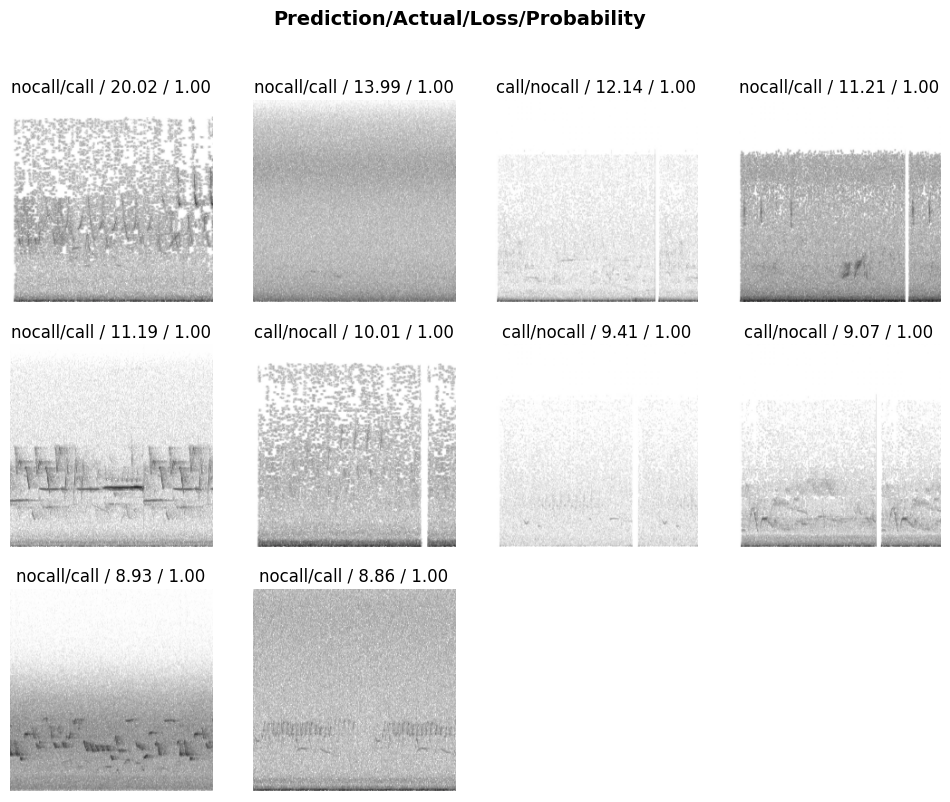

In [114]:
interpreter.plot_top_losses(10)

In [26]:
cleaner = ImageClassifierCleaner(learn)

In [27]:
cleaner

### Once an effort has been made to identify the mis-labelled images, run the following functions to re-label these items in the training set

Currently the only indication that an item is mis-labelled is the spectrogram. If necessary, write another function to listen to the audio associated with the spectrogram. This will involve loading the pandas dataframe and passing filenames 

In [ ]:
# Delete bad images
for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink()
    
# Recategorize mislabelled images
for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

# Listening to clips with the highest error. 

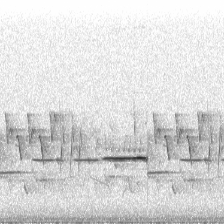

In [54]:
high_loss_path = cleaner.fns[3]
image = Image.open((high_loss_path))
image

In [81]:
def get_filename_from_path(path):
    return str(path).split('/')[-1].split('.')[0]

In [94]:
fn = get_filename_from_path(high_loss_path)

Here we can iterate throught the most lossy images, and extract the filenames. To listen to these recordings we'd just need to extract the recording id from the database:


In [100]:
from opensoundscape import Audio
listen = Audio.from_file(f'{data_path}/raw/call/audio/{fn}.flac')

In [101]:
listen

<Audio(samples=(63200,), sample_rate=32000)>

This example shows how taking the clip out of context will make aural confirmation harder. It's helpful to have heard a few positive calls then 'tune in' to be able to compare to the rest of the soundscape. 